Imports

In [1]:
import pandas as pd
import datetime
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import canada_holiday

import seaborn as sns
from sklearn import preprocessing

from pyhelpers.store import save_fig, save_svg_as_emf
import subprocess
import  aspose.cells 
from aspose.cells import Workbook

In [2]:
#%% Student directory
hanad_run = ["./data", 1]
clover_run = ["./data", 2]
joseph_laptop_run = ["C:\\Users\\sposa\\Documents\\GitHub\\power-forecasting-capstone\\data", 3]
joseph_pc_run = ["D:\\Users\\Joseph\\Documents\\GitHub\\power-forecasting-capstone\\data", 3]
janna_run = ["../data", 4]

###############################################################################
############### MAKE SURE TO CHANGE BEFORE RUNNING CODE #######################
###############################################################################
# Paste student name_run for whoever is running the code
run_student = janna_run
if (run_student[1] == joseph_laptop_run[1]):
    print("JOSEPH IS RUNNING!")
elif (run_student[1] == hanad_run[1]):
    print("HANAD IS RUNNING!")
elif (run_student[1] == janna_run[1]):
    print("JANNA IS RUNNING!")
elif (run_student[1] == clover_run[1]):
    print("CLOVER IS RUNNING!")
else:
    print("ERROR!! NO ELIGIBLE STUDENT!")
            
#%% User input

# FSA - Forward Section Area (first 3 characters of Postal Code)
#       L8K = Neighborhood in Hamilton (Link to FSA Map: https://www.prospectsinfluential.com/wp-content/uploads/2017/09/Interactive-Canadian-FSA-Map.pdf)
fsa_list = ['L9G']

# GUI INPUT
fsa_chosen = "L9G"

years = ['2018', '2019', '2020', '2021', '2022', '2023']
#years = ['2018']

# Jan - 01
# Feb - 02
# Mar - 03
# Apr - 04
# May - 05
# Jun - 06
# Jul - 07
# Aug - 08
# Sep - 09
# Oct - 10
# Nov - 11
# Dec - 12
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

months_name = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#%% Input files (PRE-PROCESSING)
dirs_inputs = run_student[0]

dirs_hourly_consumption_demand = os.path.join(dirs_inputs, "Hourly_Demand_Data")

###############################################################################
# Dictionary for reading in hourly consumption by FSA
###############################################################################
# FSA -> Year -> Month -> Value
hourly_consumption_data_dic_by_month = {}

for fsa in fsa_list:
    hourly_consumption_data_dic_by_month[fsa] = {} # Initialize FSA dictionary
    for year in years:
        hourly_consumption_data_dic_by_month[fsa][year] = {} # Initialize yearly dictionary
        
        for month in months:
            hourly_consumption_data_dic_by_month[fsa][year][month] = {} # Initialize monthly dictionary
            
            # Initialize dataframes to be used
            hourly_data_date = pd.DataFrame()
            hourly_data_res = pd.DataFrame()
            hourly_data_res_fsa = pd.DataFrame()
            hourly_data_hour_sum = pd.DataFrame()
            
            hourly_data_string = "PUB_HourlyConsumptionByFSA_"+year+month+"_v1.csv"
            
            # Use try and catch if problems reading input data
            try:
                # Not cooked yet, we are going to let it COOK below
                file_path = os.path.join(dirs_hourly_consumption_demand, hourly_data_string)
                hourly_data_raw = pd.read_csv(file_path, skiprows=3, header = 0, usecols= ['FSA', 'DATE', 'HOUR', 'CUSTOMER_TYPE', 'TOTAL_CONSUMPTION'])
            except FileNotFoundError: # not all months had a file (for example, 2024 only has up to may)
                continue
            except ValueError: # skiprows=x does not match the "normal sequence" of 3. For example, 2023 08 data had a different skip_row value
                hourly_data_raw = pd.read_csv(file_path, skiprows=7, header = 0, usecols= ['FSA', 'DATE', 'HOUR', 'CUSTOMER_TYPE', 'TOTAL_CONSUMPTION'])
       
            # Convert Date into year, month, day
            hourly_data_fix_date = hourly_data_raw
            hourly_data_fix_date['DATE'] = pd.to_datetime(hourly_data_raw['DATE'])
            hourly_data_fix_date['YEAR'] = hourly_data_fix_date['DATE'].dt.year
            hourly_data_fix_date['MONTH'] = hourly_data_fix_date['DATE'].dt.month
            hourly_data_fix_date['DAY'] = hourly_data_fix_date['DATE'].dt.day
            
            # Filter out only residential data
            hourly_data_res = hourly_data_fix_date.loc[hourly_data_fix_date['CUSTOMER_TYPE'] == "Residential"].reset_index(drop=True)
            
            # Then filter out by the fsa
            hourly_data_res_fsa = hourly_data_res.loc[hourly_data_res['FSA'] == fsa].reset_index(drop=True)
            
            # Take the sum if fsa has more than 1 date (this is because there are different pay codes in residential loads)
            hourly_data_hour_sum = hourly_data_res_fsa.groupby(["FSA", "CUSTOMER_TYPE", "YEAR", "MONTH", "DAY", "HOUR", "DATE"]).TOTAL_CONSUMPTION.sum().reset_index()
            
            
            hourly_consumption_data_dic_by_month[fsa][year][month] = hourly_data_hour_sum
            
            
            print(hourly_data_string)

###############################################################################
# Conversion between FSA and latitude longitude - NOT IMPORTANT NOW
###############################################################################
dirs_hourly_weather = os.path.join(dirs_inputs, "Weather_Data\\Hamilton_Weather\\")

###############################################################################
# Dictionary for reading in weather data
###############################################################################
# FSA -> Year -> Month -> Value

hourly_weather_data_dic_by_month = {}

for fsa in fsa_list:
    hourly_weather_data_dic_by_month[fsa] = {} # Initialize FSA dictionary
    for year in years:
        hourly_weather_data_dic_by_month[fsa][year] = {} # Initialize yearly dictionary
        
        for month in months:
            hourly_weather_data_dic_by_month[fsa][year][month] = {} # Initialize monthly dictionary
            
            # # Initialize dataframes to be used
            # hourly_data_date = pd.DataFrame()
            # hourly_data_res = pd.DataFrame()
            # hourly_data_res_fsa = pd.DataFrame()
            # hourly_data_hour_sum = pd.DataFrame()
            climate_id = "6153193"
            weather_data_string = "en_climate_hourly_ON_" + climate_id + "_" + month + "-" + year + "_P1H.csv"
            
            # Use try and catch if problems reading input data
            try:
                # Not cooked yet, we are going to let it COOK below
                ## TO DO: Calculate Hmdx using existing data (Link: https://weather.mcmaster.ca/parameter_calculation)
                file_path = os.path.join(dirs_hourly_weather, weather_data_string)
                hourly_data_raw = pd.read_csv(file_path, skiprows=0, header = 0, usecols= ['Climate ID', 'Date/Time (LST)', 'Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)', 'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Wind Chill', 'Weather'])
            except FileNotFoundError: # not all months had a file (for example, 2024 only has up to may)
                continue
            # except ValueError: # skiprows=x does not match the "normal sequence" of 3. For example, 2023 08 data had a different skip_row value
            #     hourly_data_raw = pd.read_csv(dirs_hourly_weather+weather_data_string, skiprows=7, header = 0, usecols= ['FSA', 'DATE', 'HOUR', 'CUSTOMER_TYPE', 'TOTAL_CONSUMPTION'])
       
            # Convert Date into year, month, day
            hourly_data_fix_date = hourly_data_raw
            hourly_data_fix_date['DATE'] = pd.to_datetime(hourly_data_raw['Date/Time (LST)'])
            hourly_data_fix_date['YEAR'] = hourly_data_fix_date['DATE'].dt.year
            hourly_data_fix_date['MONTH'] = hourly_data_fix_date['DATE'].dt.month
            hourly_data_fix_date['DAY'] = hourly_data_fix_date['DATE'].dt.day
            hourly_data_fix_date['HOUR'] = hourly_data_fix_date['DATE'].dt.hour
            hourly_data_fix_date['HOUR'] = hourly_data_fix_date['HOUR']+1  
    
            # Manual Calculation for WindChill
            hourly_data_fix_date['WIND CHILL CALCULATION'] = 13.12 + hourly_data_fix_date['Temp (°C)']*0.6125 - 11.37 * hourly_data_fix_date['Wind Spd (km/h)']**0.16 + 0.3965 * hourly_data_fix_date['Temp (°C)'] * hourly_data_fix_date['Wind Spd (km/h)']**0.16
            
            # Change Temperature column names so it does not have symbols anymore
            hourly_data_fix_date.rename(columns = {'Temp (°C)':'Temp (C)', 'Dew Point Temp (°C)':'Dew Point Temp (C)'}, inplace = True)
            
            hourly_weather_data_dic_by_month[fsa][year][month] = hourly_data_fix_date
            
            print(weather_data_string)

###############################################################################
# Calendar Variables
###############################################################################

# Add weekdays to hourly consumption dataframe
# Monday = 0 
# Tuesday = 1
# Wednesday = 2
# Thursday = 3
# Friday = 4 
# Saturday = 5
# Sunday = 6

# Add season to hourly consumption dataframe
# As per OEB:
# Winter(1) = November (Including) to April (Including)
# Summer(0) = May (Including) to October (Including)
for year in years:        
    for month in months:
        try:
            # Get day of week and check if it is a weekend or weekday
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["DAY_OF_WEEK"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["DATE"].dt.weekday
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKEND"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["DAY_OF_WEEK"]>4
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKDAY"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["DAY_OF_WEEK"]<5
            
            # Convert boolean of weekend or weekday to integer numbers (1-True, 0-False)
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKEND"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKEND"].astype(int)
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKDAY"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["WEEKDAY"].astype(int)
            
            # Get Season and check if it is winter or summer
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["SEASON"] = (hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["MONTH"]<5) | (hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["MONTH"]>10)
            
            # Convert boolean of weekend or weekday to integer numbers (1-Winter, 0-Summer)
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["SEASON"] = hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["SEASON"].astype(int)
            
            
            
            
            # Pad the holiday column with zeros to initialize it
            hourly_consumption_data_dic_by_month[fsa_chosen][year][month]["HOLIDAY"] = 0
            
            for index, row in  hourly_consumption_data_dic_by_month[fsa_chosen][year][month].iterrows():
                date_temp = date(row["YEAR"], row["MONTH"], row["DAY"])
                if (row["HOUR"] == 1):
                    if canada_holiday.is_holiday(date_temp, "Ontario"):
                        hourly_consumption_data_dic_by_month[fsa_chosen][year][month].loc[index, "HOLIDAY"] = 1
                        temp_value = 1
                    else:
                        temp_value = 0
                else:
                    hourly_consumption_data_dic_by_month[fsa_chosen][year][month].loc[index, "HOLIDAY"] = temp_value
        except KeyError:
            continue

###############################################################################
# X and Y Dataframes
###############################################################################
X_df = pd.DataFrame()
Y_df = pd.DataFrame()

# Combine hourly data by month into the X_df
for year in years:        
    for month in months:
        try:
            # Extract the monthly hourly data for x variables
            hourly_data_consumption_by_month_X = hourly_consumption_data_dic_by_month[fsa_chosen][year][month].drop(["FSA", "CUSTOMER_TYPE", "TOTAL_CONSUMPTION", "DATE"], axis=1)
            hourly_data_weather_by_month_X = hourly_weather_data_dic_by_month[fsa_chosen][year][month].drop(['Climate ID', 'Date/Time (LST)', 'Wind Dir (10s deg)', 'Visibility (km)', 'Stn Press (kPa)', 'Weather', 'DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR'], axis=1)
            
            
            # Combine all hourly data for x variables
            hourly_data_by_month_X = pd.concat([hourly_data_consumption_by_month_X, hourly_data_weather_by_month_X], axis = 1)
            
            # Extract the monthly hourly data for y variables
            hourly_data_by_month_Y = hourly_consumption_data_dic_by_month[fsa_chosen][year][month].drop(["FSA", "CUSTOMER_TYPE", "DATE", "DAY_OF_WEEK", "WEEKEND", "WEEKDAY", "SEASON", "HOLIDAY"], axis=1)
            
            
            X_df = pd.concat([X_df, hourly_data_by_month_X], ignore_index=True)
            Y_df = pd.concat([Y_df, hourly_data_by_month_Y], ignore_index=True)
        except KeyError:
            continue

###############################################################################
# Cleaning up X_df dataframe
###############################################################################

# Exclude "Wind Chill" column
X_without_bad_windchill = X_df.drop(columns="Wind Chill")

## Smooth out missing data
#    METHOD FOR MISSING WEATHER DATA: If value is blank, set black as average of pervious and next values
# Get columns in dataframe and cycle through them in a for loop
X_columns = X_without_bad_windchill.columns
for column in X_columns:
    # Skip over date/time columns
    if column == "YEAR" or column == "MONTH" or column == "DAY" or column == "HOUR":
        continue

    #print("Current Column: " + column) # Checking what columns make it here
    #print("\n")
    counter_adjacent_nan = 0
    # For current column, iterate through all rough
    for index, row in X_without_bad_windchill.iterrows():
        # Check if there are more than 2 nan values
        if (counter_adjacent_nan>1):
            counter_adjacent_nan -= 1
            continue
        # Check if value for current index and column is missing
        #if row[column] != row[column]:
        if math.isnan(row[column]):
            #print("MISSING DATA FOUND AT Index: " , str(index) , " | Column: " + column + " | Value: " + str(row[column]))
            
            # If found, take need to take linear interpolation between last actual value and next actual value (need to interpolate any consectutively missing data points too!)
            # Finding last actual data point
            last_data_point = X_without_bad_windchill.loc[index-1, column]
            #print("Last viable data point: " + str(last_data_point)  + "\n")
            
            # Find next available data point
            counter = 0
            not_found = True
            while not_found == True:
                counter += 1

                try: # Try to get value of next data point
                    next_data_point = X_without_bad_windchill.loc[index+counter, column]
                except KeyError: # If there are NaN values at the end of the data frame, set the value of the next data point to be eqaul last data point
                    next_data_point = last_data_point

                # Check if variable is a real value (NaN values wil ALWAYS fail this condition)
                if next_data_point == next_data_point:
                    # If found, set not_found to False and leave loop
                    not_found = False
            
            # Get linear interpolation of data
            interpolated_data = np.linspace(start=last_data_point, stop=next_data_point, num=counter+1, endpoint = False)[1:]
            

            # Give interpolated values to missing data points
            counter = 0
            counter_adjacent_nan=0
            for new_value in interpolated_data:
                X_without_bad_windchill.loc[index+counter, column] = new_value
                #print(" NEW INTERPOLATED VALUE = " + str(X_without_bad_windchill.loc[index+counter, column]))
                counter += 1
                counter_adjacent_nan += 1
X_df_cleaned = X_without_bad_windchill

# Add Date back into X_df_cleaned variable
X_df_cleaned["DATE"] = 0
for index, row in  X_df_cleaned.iterrows():
    X_df_cleaned.loc[index, "DATE"] = date(int(row["YEAR"]),int(row["MONTH"]),int(row["DAY"]))

# Convert year, month, day, hour to boolean values

# Day range 1 to 31
days = [*range(1, 32)]
# Hour range 1 to 24
hours = [*range(1, 25)]

for year in years:
    X_df_cleaned[year] = X_df_cleaned["YEAR"]==int(year)
    X_df_cleaned[year] = X_df_cleaned[year].astype(int)

for month in months_name:
    X_df_cleaned[month] = X_df_cleaned["MONTH"]==int(months_name.index(month)+1)
    X_df_cleaned[month] = X_df_cleaned[month].astype(int)

for day in days:
    X_df_cleaned["DAY_"+str(day)] = X_df_cleaned["DAY"]==int(day)
    X_df_cleaned["DAY_"+str(day)] = X_df_cleaned["DAY_"+str(day)].astype(int)

for hour in hours:
    X_df_cleaned["HOUR_"+str(hour)] = X_df_cleaned["HOUR"]==int(hour)
    X_df_cleaned["HOUR_"+str(hour)] = X_df_cleaned["HOUR_"+str(hour)].astype(int)

X_df_cleaned_output = X_df_cleaned.drop(['YEAR', 'MONTH', 'DAY', 'HOUR', 'DATE', 'WEEKDAY', 'DAY_OF_WEEK'], axis=1)

###############################################################################
# Export X and Y Dataframes to CSV
###############################################################################
dirs_dataframes = os.path.join(dirs_inputs, "X_Y_Inputs")
X_df_output_string =  os.path.join(dirs_dataframes, "X_df_"+fsa_chosen+".csv")
X_df_cleaned_output.to_csv(X_df_output_string, index=False)
Y_df_output_string =  os.path.join(dirs_dataframes, "Y_df_"+fsa_chosen+".csv")
Y_df["TOTAL_CONSUMPTION"].to_csv(Y_df_output_string, index=False)

JANNA IS RUNNING!
PUB_HourlyConsumptionByFSA_201801_v1.csv
PUB_HourlyConsumptionByFSA_201802_v1.csv
PUB_HourlyConsumptionByFSA_201803_v1.csv
PUB_HourlyConsumptionByFSA_201804_v1.csv
PUB_HourlyConsumptionByFSA_201805_v1.csv
PUB_HourlyConsumptionByFSA_201806_v1.csv
PUB_HourlyConsumptionByFSA_201807_v1.csv
PUB_HourlyConsumptionByFSA_201808_v1.csv
PUB_HourlyConsumptionByFSA_201809_v1.csv
PUB_HourlyConsumptionByFSA_201810_v1.csv
PUB_HourlyConsumptionByFSA_201811_v1.csv
PUB_HourlyConsumptionByFSA_201812_v1.csv
PUB_HourlyConsumptionByFSA_201901_v1.csv
PUB_HourlyConsumptionByFSA_201902_v1.csv
PUB_HourlyConsumptionByFSA_201903_v1.csv
PUB_HourlyConsumptionByFSA_201904_v1.csv
PUB_HourlyConsumptionByFSA_201905_v1.csv
PUB_HourlyConsumptionByFSA_201906_v1.csv
PUB_HourlyConsumptionByFSA_201907_v1.csv
PUB_HourlyConsumptionByFSA_201908_v1.csv
PUB_HourlyConsumptionByFSA_201909_v1.csv
PUB_HourlyConsumptionByFSA_201910_v1.csv
PUB_HourlyConsumptionByFSA_201911_v1.csv
PUB_HourlyConsumptionByFSA_201912_v1.cs

C:\Users\janna\AppData\Local\Temp\ipykernel_15296\1300456599.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2018-01-01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_df_cleaned.loc[index, "DATE"] = date(int(row["YEAR"]),int(row["MONTH"]),int(row["DAY"]))


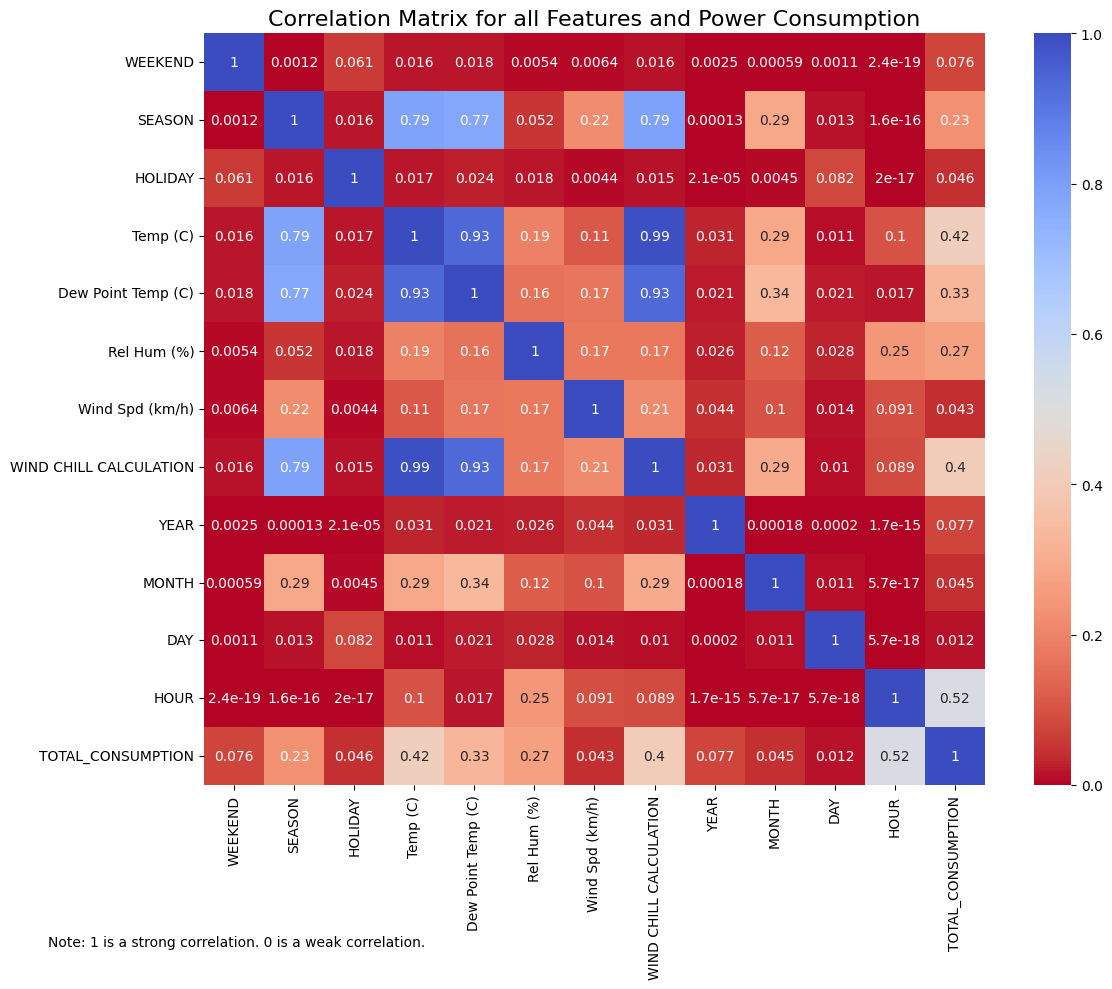

In [3]:
#Drop Calendar Variables

X_df_no_calendar = X_df_cleaned_output.drop(["2018", "2019", "2020", "2021", "2022", "2023", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "DAY_1", "DAY_2", "DAY_3", "DAY_4", "DAY_5", "DAY_6", "DAY_7", "DAY_8", "DAY_9", "DAY_10", "DAY_11", "DAY_12", "DAY_13", "DAY_14", "DAY_15", "DAY_16", "DAY_17", "DAY_18", "DAY_19", "DAY_20", "DAY_21", "DAY_22", "DAY_23", "DAY_24", "DAY_25", "DAY_26", "DAY_27", "DAY_28", "DAY_29", "DAY_30", "DAY_31", "HOUR_1", "HOUR_2", "HOUR_3", "HOUR_4", "HOUR_5", "HOUR_6", "HOUR_7", "HOUR_8", "HOUR_9", "HOUR_10", "HOUR_11", "HOUR_12", "HOUR_13", "HOUR_14", "HOUR_15", "HOUR_16", "HOUR_17", "HOUR_18", "HOUR_19", "HOUR_20", "HOUR_21", "HOUR_22", "HOUR_23", "HOUR_24"], axis=1)


# Combine the DataFrames
combined_df = pd.concat([X_df_no_calendar, Y_df], axis=1)

# Compute the correlation matrix
correlation_matrix = combined_df.corr()

# Use the absolute values of the correlation matrix
abs_correlation_matrix = correlation_matrix.abs()

# Set the figure size for better visibility
plt.figure(figsize=(12, 10))  # Adjust the width and height as needed

# Plot the heatmap (_r flips the colour scheme)
sns.heatmap(abs_correlation_matrix, annot=True, cmap='coolwarm_r')

# Add title
plt.title("Linear Correlation Matrix", fontsize=16)

# Add textbox in the bottom left corner to explain
plt.text(-0.20, -0.20, "Note: 1 is a strong correlation. 0 is a weak correlation.", 
         fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)

# Adjust layout to make room for labels
plt.tight_layout()

# Show the plot
plt.show()


Non-Linear Correlation Matrices

Spearman Rank Correlation Matrix

In [4]:
# Compute Spearman correlation matrix
spearman_corr = combined_df.corr(method='spearman')
print(spearman_corr)

                         WEEKEND    SEASON   HOLIDAY  Temp (C)  \
WEEKEND                 1.000000 -0.001155 -0.061439 -0.015181   
SEASON                 -0.001155  1.000000 -0.016430 -0.798141   
HOLIDAY                -0.061439 -0.016430  1.000000  0.017717   
Temp (C)               -0.015181 -0.798141  0.017717  1.000000   
Dew Point Temp (C)     -0.016097 -0.789278  0.024976  0.933722   
Rel Hum (%)            -0.005152  0.032646  0.020514 -0.155183   
Wind Spd (km/h)        -0.005113  0.209215  0.006580 -0.095493   
WIND CHILL CALCULATION -0.014406 -0.800297  0.016773  0.988295   
YEAR                    0.002451 -0.000135  0.000021  0.030779   
MONTH                   0.000589 -0.283813 -0.004386  0.278092   
DAY                    -0.001098 -0.012520 -0.081721  0.012289   
HOUR                    0.000000  0.000000  0.000000  0.098530   
TOTAL_CONSUMPTION       0.093698 -0.145714  0.042802  0.297809   

                        Dew Point Temp (C)  Rel Hum (%)  Wind Spd (km/h)  \

Visualizing Spearman Matrix

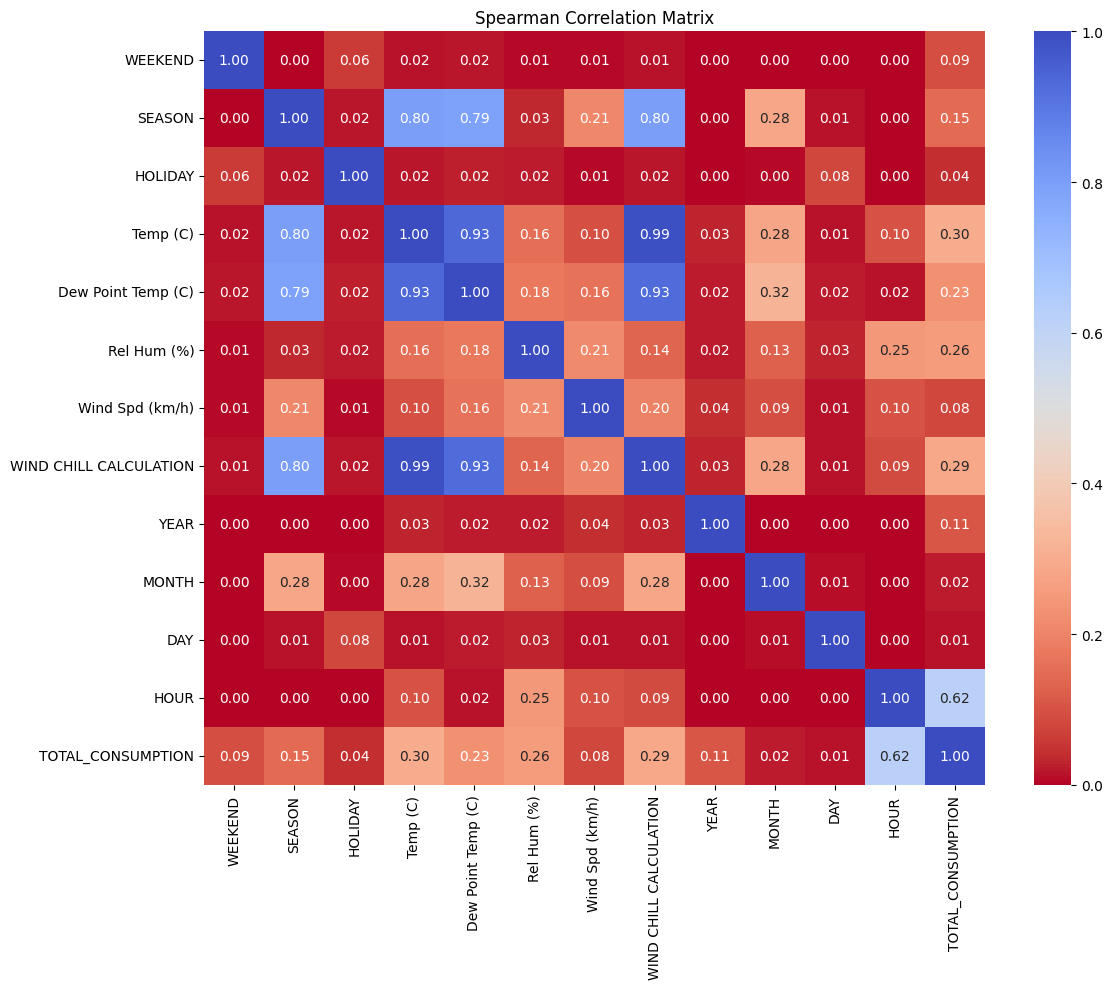

In [12]:
# Heatmap for visualization
abs_spearman_corr = spearman_corr.abs()
# Set the figure size for better visibility
plt.figure(figsize=(12, 10))  # Adjust the width and height as needed
sns.heatmap(abs_spearman_corr, annot=True, cmap='coolwarm_r', fmt='.2f')
plt.title('Spearman Correlation Matrix')

# Adjust layout to make room for labels
plt.tight_layout()
plt.show()

C:\Users\janna\AppData\Local\Temp\ipykernel_15296\1205857164.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mi
C:\Users\janna\AppData\Local\Temp\ipykernel_15296\1205857164.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mi
C:\Users\janna\AppData\Local\Temp\ipykernel_15296\1205857164.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mi_matrix[i, j] = mi
C:\Users\janna\AppData\Local\Temp\ipykernel_15296\1205857164.py:

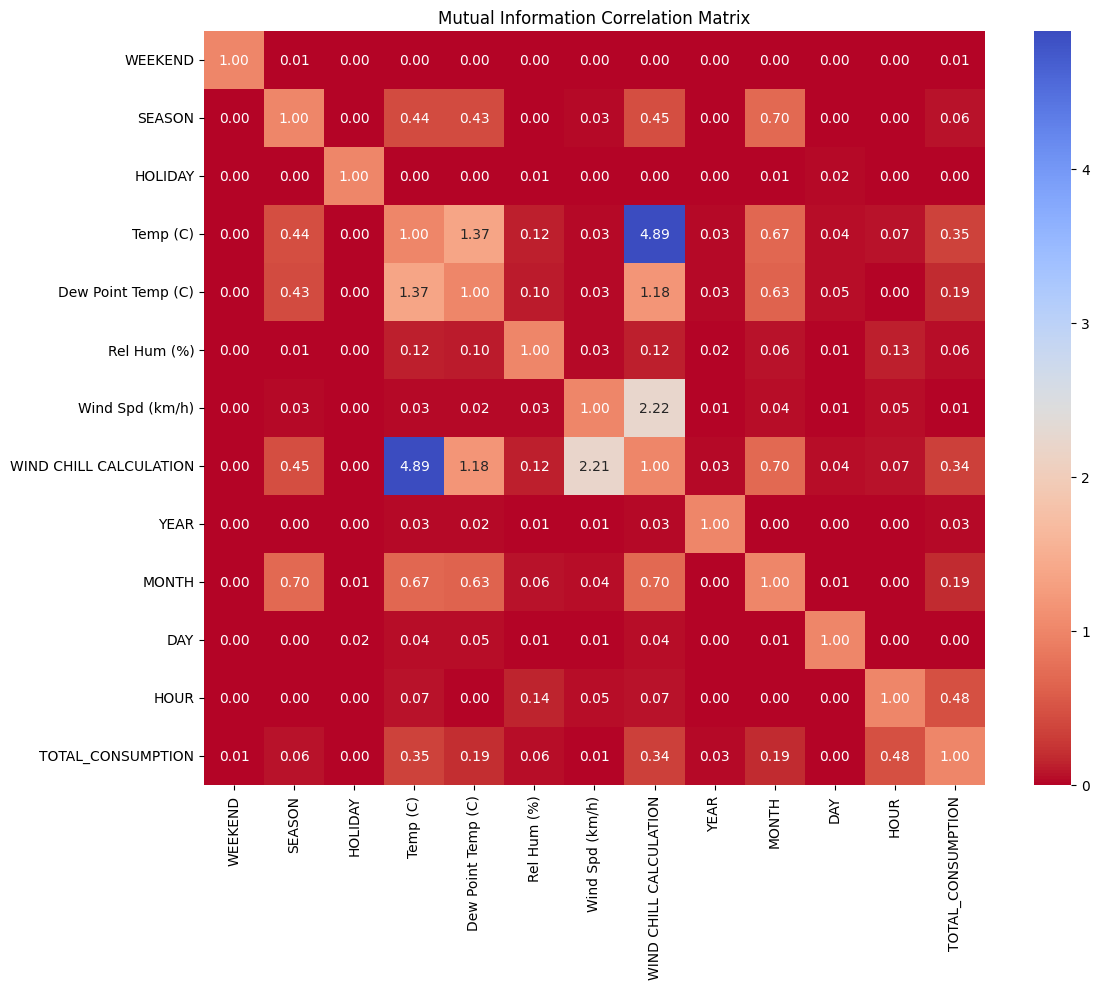

In [13]:
from sklearn.feature_selection import mutual_info_regression

# Function to compute mutual information matrix
def mutual_info_matrix(df):
    n = df.shape[1]
    mi_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                mi_matrix[i, j] = 1  # Perfect correlation with itself
            else:
                mi = mutual_info_regression(df.iloc[:, [i]], df.iloc[:, j], discrete_features=False)
                mi_matrix[i, j] = mi
    return pd.DataFrame(mi_matrix, columns=df.columns, index=df.columns)

# Compute the mutual information matrix
mi_corr = mutual_info_matrix(combined_df)

# Visualize using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(mi_corr, annot=True, cmap='coolwarm_r', fmt='.2f', cbar=True)
plt.title('Mutual Information Correlation Matrix')
plt.tight_layout()
plt.show()


Normalizing X_df

In [7]:
from sklearn import preprocessing

# Select the columns to normalize (4th to 8th columns)
columns_to_normalize = X_df_cleaned_output.columns[3:8]  # Adjust index as needed

min_max_scaler = preprocessing.MinMaxScaler()

# Normalize the selected columns
X_train_minmax = X_df_cleaned_output.copy()  # Create a copy to avoid modifying the original DataFrame
X_train_minmax[columns_to_normalize] = min_max_scaler.fit_transform(X_df_cleaned_output[columns_to_normalize])

# Save the normalized DataFrame to a new DataFrame
X_train_minmax_df = X_train_minmax

# Specify the correct path for saving the CSV
dirs_dataframes = os.path.join(dirs_inputs, "X_Y_Inputs")
X_train_minmax_output_string = os.path.join(dirs_dataframes, "X_train_minmax.csv")

# Save the DataFrame to CSV
X_train_minmax_df.to_csv(X_train_minmax_output_string, index=False)


Normalizing Y_df

In [8]:
import joblib  # For saving the scaler

# Create a new DataFrame with only the TOTAL_CONSUMPTION column
Y_df_total_consumption = Y_df[['TOTAL_CONSUMPTION']].copy()  # Ensure it's a DataFrame

# Create a MinMaxScaler instance
min_max_scaler_y = preprocessing.MinMaxScaler()

# Normalize the TOTAL_CONSUMPTION column
Y_df_normalized = Y_df_total_consumption.copy()  # Create a copy to avoid modifying the original DataFrame
Y_df_normalized['TOTAL_CONSUMPTION'] = min_max_scaler_y.fit_transform(Y_df_total_consumption)

# Save the scaler for later use
scaler_y_filename = os.path.join(dirs_inputs, "X_Y_Inputs", "min_max_scaler_y.pkl")
joblib.dump(min_max_scaler_y, scaler_y_filename)

# Specify the correct path for saving the normalized CSV
Y_df_normalized_output_string = os.path.join(dirs_dataframes, "Y_df_normalized.csv")

# Save only the TOTAL_CONSUMPTION column to CSV
Y_df_normalized[['TOTAL_CONSUMPTION']].to_csv(Y_df_normalized_output_string, index=False)

Denormalizing Y_df

In [9]:
import joblib  # To load the scaler
# Load the scaler
loaded_scaler_y = joblib.load(scaler_y_filename)

# Denormalize the TOTAL_CONSUMPTION column
denormalized_y = loaded_scaler_y.inverse_transform(Y_df_normalized[['TOTAL_CONSUMPTION']])

# Create a new DataFrame for the denormalized values
denormalized_y_df = pd.DataFrame(denormalized_y, columns=['TOTAL_CONSUMPTION'])

# Path for Y_df_denormalized
denormalized_y_output_string = os.path.join(dirs_dataframes, "Y_df_denormalized.csv")

# Save only the TOTAL_CONSUMPTION column to CSV
denormalized_y_df.to_csv(denormalized_y_output_string, index=False)